In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

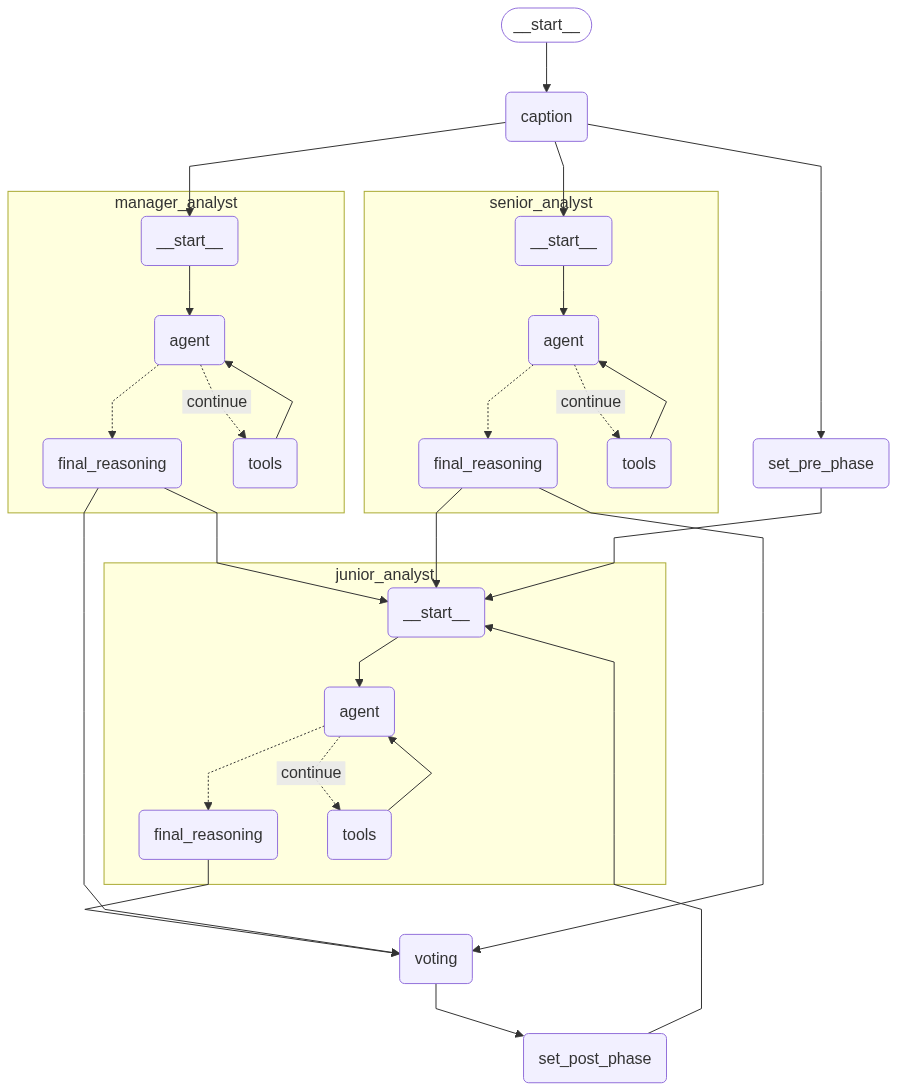

AttributeError: 'CompiledStateGraph' object has no attribute 'run'

In [12]:
from typing import Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from src.core.nodes.caption_node import caption_node
from src.core.nodes.voting_node import voting_node
from src.core.state import ViReAgentState
from src.core.graph_builder.sub_graph import SubGraphBuilder
from IPython.display import Image, display

def set_pre_phase(state: ViReAgentState) -> ViReAgentState:
    return state.update(phase="prevote")

def set_post_phase(state: ViReAgentState) -> ViReAgentState:
    return state.update(phase="postvote")

class MainGraphBuilder:
    """Builder for the main multi-agent workflow with pre/post phase for Junior agent"""

    def __init__(self, tools_registry: Dict[str, Any]):
        self.tools_registry = tools_registry
        self.subgraph_builder = SubGraphBuilder(tools_registry)

    def create_main_workflow(self):
        """Create the main multi-agent workflow"""
        main_workflow = StateGraph(ViReAgentState)


        main_workflow.add_node("set_pre_phase", set_pre_phase)
        main_workflow.add_node("set_post_phase", set_post_phase)

        # Core nodes
        # Caption generation
        main_workflow.add_node("caption", caption_node)
        # Subgraphs for roles
        main_workflow.add_node("junior_analyst", self.subgraph_builder.create_junior_subgraph())
        main_workflow.add_node("senior_analyst", self.subgraph_builder.create_senior_subgraph())
        main_workflow.add_node("manager_analyst", self.subgraph_builder.create_manager_subgraph())
        # Voting aggregator
        main_workflow.add_node("voting", voting_node)

        # Edges: initial flow into Junior (pre-vote) and parallel reviewers
        main_workflow.add_edge(START, "caption")
        main_workflow.add_edge("caption", "set_pre_phase")
        main_workflow.add_edge("set_pre_phase", "junior_analyst")
        main_workflow.add_edge("caption", "senior_analyst")
        main_workflow.add_edge("caption", "manager_analyst")

        # Voting from all reviewers
        main_workflow.add_edge("junior_analyst", "voting")
        main_workflow.add_edge("senior_analyst", "voting")
        main_workflow.add_edge("manager_analyst", "voting")
        

        main_workflow.add_edge("voting", "set_post_phase")
        main_workflow.add_edge("set_post_phase", "junior_analyst")
        main_workflow.add_edge("senior_analyst", "junior_analyst")
        main_workflow.add_edge("manager_analyst", "junior_analyst")
        
        main_workflow.add_edge("junior_analyst", END)

        return main_workflow.compile()


def simulate_workflow() -> None:
    """Basic simulation of the VQA-X workflow"""
    # Instantiate the graph
    builder = MainGraphBuilder(tools_registry={})
    workflow = builder.create_main_workflow()
    display(Image(workflow.get_graph(xray=1).draw_mermaid_png()))
    # Sample user query for demonstration
    sample_query = "Describe the content of the image showing a cat on a mat"

    # Run the workflow
    results = workflow.run(user_query=sample_query)

    # Display outputs by node
    print("=== VQA-X Workflow Simulation Results ===")
    for node_name, output in results.items():
        print(f"{node_name}: {output}\n")


if __name__ == "__main__":
    simulate_workflow()
